In [1]:
import bioframe as bf
from datasets import load_dataset
from gpn.data import Genome, load_table, load_dataset_from_file_or_dir
from liftover import get_lifter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFdr
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
import torch
from tqdm import tqdm
import yaml

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [141]:
#dataset = "Height"
#dataset = "IBD"
dataset = "merged"
V = pd.read_parquet(f"../../results/dataset/gwas_gokcen_{dataset}_cre_matched_9/test.parquet")
V

,chrom,pos,ref,alt,PIP,MAF,trait,label,consequence,tss_dist
0,1,1057464,T,A,0.000369,0.081404,,False,DNase-H3K4me3,16841
1,1,1156987,C,T,0.007552,0.283611,,False,dELS,16892
2,1,1159750,T,C,0.006419,0.285286,,False,dELS,14129
3,1,1214801,G,C,0.004288,0.094643,,False,pELS,647
4,1,1214831,G,A,0.007452,0.093883,,False,pELS,677
...,...,...,...,...,...,...,...,...,...,...
10905,22,50271208,T,G,0.005409,0.004434,,False,pELS,827
10906,22,50418711,G,A,0.001273,0.282601,,False,dELS,730
10907,22,50532837,T,C,1.000000,0.328351,"MCH,RBC",True,pELS,330
10908,22,50563409,C,T,0.006680,0.228513,,False,pELS,489


In [142]:
features_paths = [
    "GPN-MSA_InnerProducts",
    #"CADD",
    #"Borzoi_L2",
]
features = []
for features_path in features_paths:
    df = pd.read_parquet(f"../../results/dataset/gwas_gokcen_{dataset}_cre_matched_9/features/{features_path}.parquet")
    df = df.fillna(df.mean())
    df.columns = [f"{features_path}_{col}" for col in df.columns]
    features += df.columns.tolist()
    V = pd.concat([V, df], axis=1)
features

['GPN-MSA_InnerProducts_embedding_0',
 'GPN-MSA_InnerProducts_embedding_1',
 'GPN-MSA_InnerProducts_embedding_2',
 'GPN-MSA_InnerProducts_embedding_3',
 'GPN-MSA_InnerProducts_embedding_4',
 'GPN-MSA_InnerProducts_embedding_5',
 'GPN-MSA_InnerProducts_embedding_6',
 'GPN-MSA_InnerProducts_embedding_7',
 'GPN-MSA_InnerProducts_embedding_8',
 'GPN-MSA_InnerProducts_embedding_9',
 'GPN-MSA_InnerProducts_embedding_10',
 'GPN-MSA_InnerProducts_embedding_11',
 'GPN-MSA_InnerProducts_embedding_12',
 'GPN-MSA_InnerProducts_embedding_13',
 'GPN-MSA_InnerProducts_embedding_14',
 'GPN-MSA_InnerProducts_embedding_15',
 'GPN-MSA_InnerProducts_embedding_16',
 'GPN-MSA_InnerProducts_embedding_17',
 'GPN-MSA_InnerProducts_embedding_18',
 'GPN-MSA_InnerProducts_embedding_19',
 'GPN-MSA_InnerProducts_embedding_20',
 'GPN-MSA_InnerProducts_embedding_21',
 'GPN-MSA_InnerProducts_embedding_22',
 'GPN-MSA_InnerProducts_embedding_23',
 'GPN-MSA_InnerProducts_embedding_24',
 'GPN-MSA_InnerProducts_embedding_2

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [143]:
# maybe should just use auprc
ranked_features = V[features].corrwith(V["label"], method="spearman").abs().sort_values(ascending=False)
ranked_features

GPN-MSA_InnerProducts_embedding_684    0.225098
GPN-MSA_InnerProducts_embedding_565    0.220817
GPN-MSA_InnerProducts_embedding_14     0.218095
GPN-MSA_InnerProducts_embedding_243    0.215760
GPN-MSA_InnerProducts_embedding_698    0.210480
                                         ...   
GPN-MSA_InnerProducts_embedding_589    0.001243
GPN-MSA_InnerProducts_embedding_388    0.001242
GPN-MSA_InnerProducts_embedding_206    0.001045
GPN-MSA_InnerProducts_embedding_49     0.000593
GPN-MSA_InnerProducts_embedding_227    0.000515
Length: 768, dtype: float64

In [93]:
#corr = V[["label"] + features].corr(method="spearman").abs()
corr = V[["label"] + ranked_features.head(50).index.values.tolist()].corr(method="spearman").abs()
corr

,label,CADD_GerpRS,GPN-MSA_InnerProducts_embedding_684,CADD_GerpRSpval,GPN-MSA_InnerProducts_embedding_565,GPN-MSA_InnerProducts_embedding_14,GPN-MSA_InnerProducts_embedding_243,GPN-MSA_InnerProducts_embedding_698,GPN-MSA_InnerProducts_embedding_661,GPN-MSA_InnerProducts_embedding_707,...,GPN-MSA_InnerProducts_embedding_302,GPN-MSA_InnerProducts_embedding_671,GPN-MSA_InnerProducts_embedding_59,GPN-MSA_InnerProducts_embedding_267,GPN-MSA_InnerProducts_embedding_78,GPN-MSA_InnerProducts_embedding_590,GPN-MSA_InnerProducts_embedding_23,GPN-MSA_InnerProducts_embedding_394,GPN-MSA_InnerProducts_embedding_454,GPN-MSA_InnerProducts_embedding_425
label,1.000000,0.278106,0.225098,0.221217,0.220817,0.218095,0.215760,0.210480,0.209461,0.206751,...,0.186695,0.186692,0.186691,0.186476,0.186474,0.185896,0.185368,0.185293,0.184905,0.184893
CADD_GerpRS,0.278106,1.000000,0.465494,0.909550,0.481937,0.453248,0.484655,0.484970,0.421874,0.510787,...,0.458756,0.462372,0.430061,0.342642,0.516211,0.505851,0.460793,0.429011,0.519165,0.497506
GPN-MSA_InnerProducts_embedding_684,0.225098,0.465494,1.000000,0.411067,0.867979,0.826144,0.773082,0.823650,0.766411,0.717750,...,0.388183,0.457766,0.577578,0.782139,0.672974,0.563441,0.438499,0.796388,0.742622,0.625556
CADD_GerpRSpval,0.221217,0.909550,0.411067,1.000000,0.432545,0.409946,0.443885,0.442396,0.379639,0.463252,...,0.407905,0.415793,0.386534,0.290997,0.473461,0.460832,0.412636,0.388195,0.475865,0.452161
GPN-MSA_InnerProducts_embedding_565,0.220817,0.481937,0.867979,0.432545,1.000000,0.816238,0.797934,0.795132,0.783579,0.807950,...,0.489908,0.641014,0.622087,0.670455,0.733182,0.720365,0.582730,0.803306,0.710696,0.704209
GPN-MSA_InnerProducts_embedding_14,0.218095,0.453248,0.826144,0.409946,0.816238,1.000000,0.692421,0.757467,0.723382,0.634984,...,0.457765,0.504958,0.628530,0.714662,0.562720,0.510192,0.464684,0.678032,0.589494,0.527873
GPN-MSA_InnerProducts_embedding_243,0.215760,0.484655,0.773082,0.443885,0.797934,0.692421,1.000000,0.773673,0.872446,0.801532,...,0.391825,0.485677,0.632492,0.578636,0.747922,0.693993,0.404381,0.812580,0.749780,0.627137
GPN-MSA_InnerProducts_embedding_698,0.210480,0.484970,0.823650,0.442396,0.795132,0.757467,0.773673,1.000000,0.723078,0.791833,...,0.462857,0.498703,0.686630,0.735161,0.677813,0.603116,0.467520,0.670005,0.705608,0.643274
GPN-MSA_InnerProducts_embedding_661,0.209461,0.421874,0.766411,0.379639,0.783579,0.723382,0.872446,0.723078,1.000000,0.718395,...,0.295057,0.396324,0.534933,0.586880,0.666780,0.588753,0.327143,0.815491,0.677811,0.551329
GPN-MSA_InnerProducts_embedding_707,0.206751,0.510787,0.717750,0.463252,0.807950,0.634984,0.801532,0.791833,0.718395,1.000000,...,0.591890,0.682866,0.637755,0.507474,0.795653,0.840802,0.628532,0.707860,0.729100,0.746689


In [94]:
from scipy.cluster.hierarchy import linkage, leaves_list

# need to do this better, label was clustering much better before

# perform hierarchical clustering
linkage_matrix = linkage(corr, method='average')
# get the reordered index
reordered_index = leaves_list(linkage_matrix)
# reorder the correlation matrix
corr = corr.iloc[reordered_index, reordered_index]
corr

,label,CADD_RemapOverlapTF,CADD_RemapOverlapCL,GPN-MSA_InnerProducts_embedding_307,CADD_GerpRS,CADD_GerpRSpval,GPN-MSA_InnerProducts_embedding_267,GPN-MSA_InnerProducts_embedding_586,GPN-MSA_InnerProducts_embedding_565,GPN-MSA_InnerProducts_embedding_759,...,GPN-MSA_InnerProducts_embedding_389,GPN-MSA_InnerProducts_embedding_757,GPN-MSA_InnerProducts_embedding_8,GPN-MSA_InnerProducts_embedding_125,GPN-MSA_InnerProducts_embedding_559,GPN-MSA_InnerProducts_embedding_680,GPN-MSA_InnerProducts_embedding_472,GPN-MSA_InnerProducts_embedding_59,GPN-MSA_InnerProducts_embedding_521,GPN-MSA_InnerProducts_embedding_605
label,1.000000,0.196979,0.189002,0.190182,0.278106,0.221217,0.186476,0.202792,0.220817,0.205723,...,0.190677,0.196102,0.191982,0.191573,0.202709,0.187983,0.193527,0.186691,0.201877,0.188570
CADD_RemapOverlapTF,0.196979,1.000000,0.977210,0.146582,0.136286,0.111095,0.352502,0.319521,0.337317,0.279827,...,0.227291,0.221424,0.198715,0.202117,0.312644,0.292415,0.314825,0.300530,0.306140,0.272961
CADD_RemapOverlapCL,0.189002,0.977210,1.000000,0.147436,0.134252,0.109407,0.341779,0.311331,0.330772,0.274521,...,0.224622,0.220066,0.197798,0.200528,0.305487,0.286450,0.306597,0.291524,0.302112,0.264701
GPN-MSA_InnerProducts_embedding_307,0.190182,0.146582,0.147436,1.000000,0.470921,0.420920,0.183585,0.283172,0.501964,0.446929,...,0.538505,0.520174,0.461060,0.495713,0.390702,0.263207,0.250806,0.332527,0.532257,0.362205
CADD_GerpRS,0.278106,0.136286,0.134252,0.470921,1.000000,0.909550,0.342642,0.442632,0.481937,0.510352,...,0.476210,0.480706,0.489478,0.494368,0.447317,0.437234,0.420479,0.430061,0.457543,0.408136
CADD_GerpRSpval,0.221217,0.111095,0.109407,0.420920,0.909550,1.000000,0.290997,0.389661,0.432545,0.465532,...,0.429072,0.429324,0.440069,0.446321,0.394741,0.393123,0.372577,0.386534,0.404494,0.363611
GPN-MSA_InnerProducts_embedding_267,0.186476,0.352502,0.341779,0.183585,0.342642,0.290997,1.000000,0.567149,0.670455,0.575709,...,0.442033,0.386813,0.312677,0.343046,0.623505,0.658220,0.694818,0.618289,0.559147,0.457948
GPN-MSA_InnerProducts_embedding_586,0.202792,0.319521,0.311331,0.283172,0.442632,0.389661,0.567149,1.000000,0.771151,0.771562,...,0.560437,0.592872,0.593749,0.567216,0.675720,0.629162,0.623908,0.516832,0.445833,0.448480
GPN-MSA_InnerProducts_embedding_565,0.220817,0.337317,0.330772,0.501964,0.481937,0.432545,0.670455,0.771151,1.000000,0.863376,...,0.728909,0.718717,0.690145,0.688008,0.816443,0.744609,0.739604,0.622087,0.606657,0.573238
GPN-MSA_InnerProducts_embedding_759,0.205723,0.279827,0.274521,0.446929,0.510352,0.465532,0.575709,0.771562,0.863376,1.000000,...,0.649102,0.697377,0.657029,0.656632,0.730802,0.683862,0.661795,0.564217,0.477872,0.466577


<Axes: >

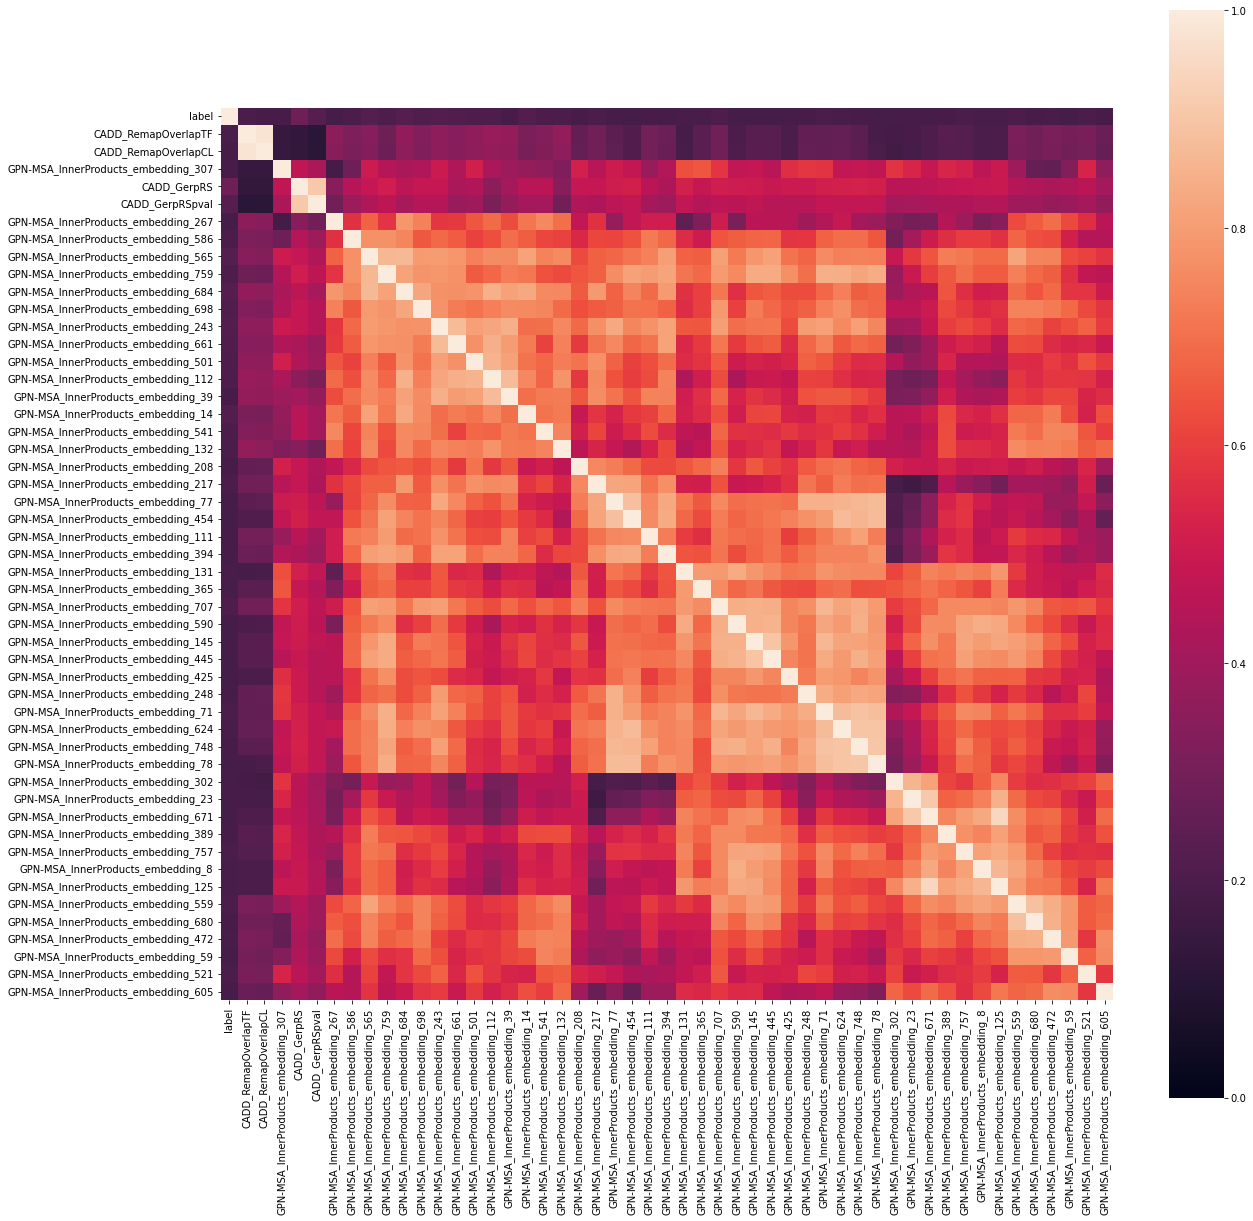

In [96]:
# TODO: should also show correlation with ref and alt (1-hot first, perhaps)
# only within GPN-MSA
# maybe 1-hot the multiplication of ref and alt (and dedup rc)

# TODO: try largest merged dataset
# TODO: filter to features with high correlation with label

label_idx = corr.columns.tolist().index('label')

idx = slice(None)
#idx = slice(45, 65)
#idx = slice(500, 700)
#idx = slice(label_idx-30, label_idx+30)

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr.iloc[idx, idx],
    square=True,
    vmin=0, vmax=1,
)
#sns.clustermap(
    #corr.iloc[idx, idx],
    #corr,
    #cmap="coolwarm",
    #figsize=(30, 30),
#)
#plt.savefig("correlation.pdf", bbox_inches="tight")

In [106]:
X = features
y = V.label
mask_train = V.chrom.isin([str(i) for i in range(1, 23, 2)] + ["X"])
X_train = X[mask_train]
y_train = y[mask_train]
X_test = X[~mask_train]
y_test = y[~mask_train]
balanced = True

clf = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', RobustScaler()),
    #('feature_selection', SelectKBest(score_func=f_classif, k=30)),
    #('feature_selection', SelectFdr(score_func=f_classif, alpha=0.05)),
    #('feature_selection', SelectFromModel(LogisticRegression(C=1e-1, penalty="l1", random_state=42, solver="saga"))),
    ('linear', LogisticRegressionCV(
        class_weight="balanced",
        scoring="roc_auc" if balanced else "average_precision",
        Cs=np.logspace(-10, 10, 41),
        cv=3,
        random_state=42,
        n_jobs=-1,
    ))
    #(
    #    'random_forest',
    #    RandomForestClassifier(
    #        class_weight="balanced",
    #        n_estimators=1000,
    #        random_state=42,
    #        n_jobs=-1,
    #    )
    #),
])
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, pred)

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['MMSp_acceptorIntron' 'MMSp_acceptor']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP

0.5800303592511384

In [144]:
traits

['IBD',
 'Height',
 'CD',
 'BMD-HT',
 'PLT',
 'TG',
 'BMI',
 'EY',
 'MNR',
 'Breast_cancer',
 'MNP']

In [ ]:
for 